In [1]:
%reset -f
%matplotlib inline
import numpy as np
import lib.io.stan
import matplotlib.pyplot as plt
import os 

In [2]:
data_dir = 'datasets/id001_ac'
results_dir = 'results/exp10/exp10.7'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/AC_network.npz')
SC = network['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = network['gain_mat']

syn_data = np.load(f'{data_dir}/AC_fit_trgt.npz')

In [ ]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = syn_data['fit_trgt'].shape[0]
I1 = 3.1
tau0 = 2857.0
epsilon = 0.1

stan_fname = 'vep-snsrfit-cntr'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)

# x0_star = np.zeros(nn)
# x_init = -2.0*np.ones(nn)
# z_init = 3.5*np.ones(nn)
# amplitude = 0.1*np.ones(ns)
# offset = 180*np.ones(ns)
# epsilon = 0.01

# param_init = {'x0_star':x0_star, 'x_init':x_init, 'z_init':z_init, 'amplitude':amplitude,
#                 'offset':offset, 'epsilon':0.1}
# param_init_file = 'param_init.R'
# lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)

# for sigma in np.arange(0.1, 0.2, 0.1):
#     data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'SC':SC, 
#             'K':K, 'gain': gain_mat, 'sigma':sigma, 'epsilon':epsilon, 'seeg':syn_data['fit_trgt']}
#     input_Rfile = f'fit_data_sigma{sigma:0.1f}.R'
#     os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
#     lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)
#     nchains = 4
#     with open('vep-snsrfit-cntr.sh','r') as fd:
#         slurm_script = fd.read().format(f'{results_dir}/Rfiles', results_dir, input_Rfile, nchains, eps)
#     with open(f'tmp/vep-snsrfit-ode-eps{eps:0.1f}.sh','w') as fd:
#         fd.write(slurm_script)
#     lib.io.stan.create_process(['sbatch',f'tmp/vep-snsrfit-ode-eps{eps:0.1f}.sh'],block=False)
    
sigma = 0.1
data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'gain':gain_mat, 'SC':SC, 'K':K, 'sigma':sigma, 'epsilon':epsilon, 'slp':syn_data['fit_trgt']}
input_Rfile = f'fit_data_sigma{sigma:0.1f}.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}', data)

cmd= f'./vep-snsrfit-cntr sample save_warmup=1 num_warmup=200 num_samples=200 adapt delta=0.8 algorithm=hmc engine=nuts \
max_depth=10 data file={results_dir}/Rfiles/{input_Rfile} output file={results_dir}/samples_sigma{sigma:0.1f}.csv refresh=5'
print(cmd.split(' '))
lib.io.stan.create_process(cmd.split(' '), block=True)

/home/anirudhnihalani/vep.stan
make: `/home/anirudhnihalani/vep.stan/vep-snsrfit-cntr' is up to date.
['./vep-snsrfit-cntr', 'sample', 'save_warmup=1', 'num_warmup=200', 'num_samples=200', 'adapt', 'delta=0.8', 'algorithm=hmc', 'engine=nuts', 'max_depth=10', 'data', 'file=results/exp10/exp10.7/Rfiles/fit_data_sigma0.1.R', 'output', 'file=results/exp10/exp10.7/samples_sigma0.1.csv', 'refresh=5']
method = sample (Default)
  sample
    num_samples = 200
    num_warmup = 200
    save_warmup = 1
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = hmc (Default)
      hmc
        engine = nuts (Default)
          nuts
            max_depth = 10 (Default)
        metric = diag_e (Default)
        stepsize = 1 (Default)
        stepsize_j

In [71]:
# import lib.io.stan
import importlib
importlib.reload(lib.io.stan)

csv_fname = 'results/exp10/exp10.7/samples_sigma0.1.csv'
nwarmup = 115
nsampling = 0
variables_of_interest = ['lp__','accept_stat__','stepsize__','treedepth__','n_leapfrog__',\
                         'divergent__', 'energy__','x0',  'x', 'mu_seeg', 'amplitude', 'offset',\
                         'x_init', 'z_init', 'epsilon']
pstr_samples_1 = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling) # read sampler diagnostics and x0 for all sampling iterations

# csv_fname = 'results/exp10/exp10.4/samples_eps0.1_chain1.csv'
# nwarmup = 1000
# nsampling = 1000
# ignore_warmup = True
# variables_of_interest = ['x','z']
# pstr_samples_2 = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup,variables_of_interest) # read 10 samples of hidden state variables x and z

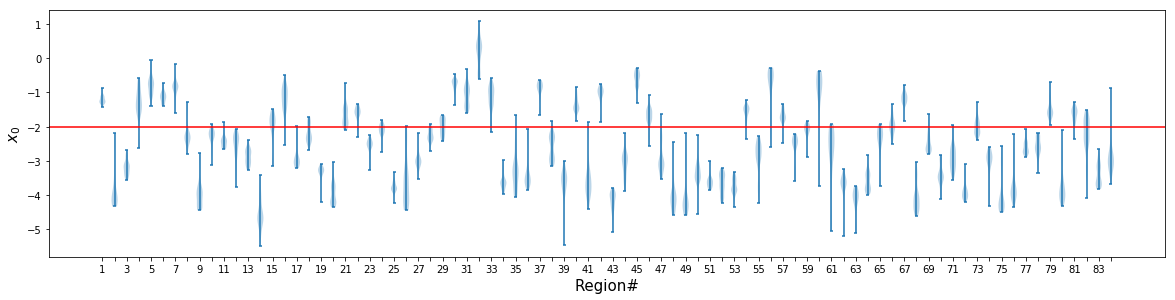

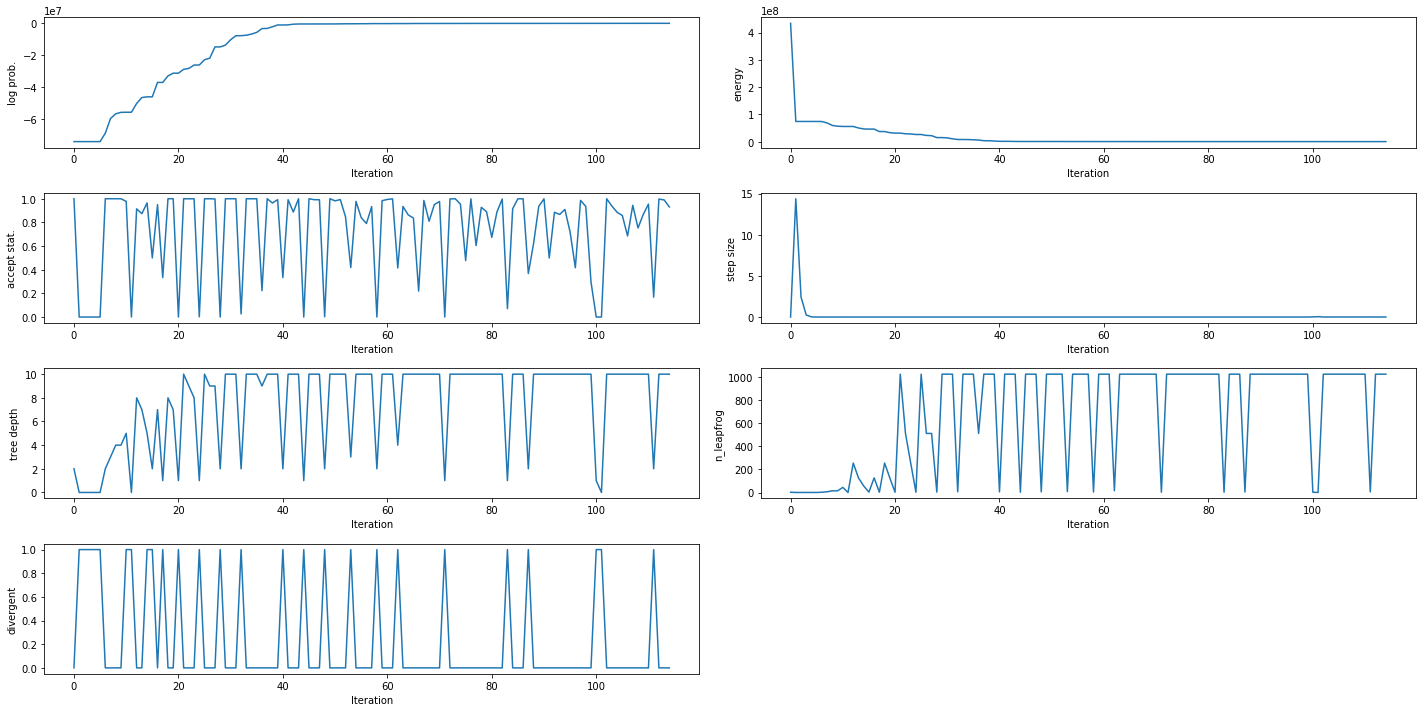

In [85]:
%matplotlib inline
import lib.plots.stan
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.violinplot(pstr_samples_1['x0'][50:]);
plt.axhline(-2.0,color='red')
xtick_labels = []
for i in range(84):
    if(i%2 == 0):
        xtick_labels.append(str(i+1))
    else:
        xtick_labels.append('')
plt.xticks(np.r_[1:85],xtick_labels);
plt.xlabel('Region#',fontsize=15);
plt.ylabel('$x_0$',fontsize=15);

lib.plots.stan.nuts_diagnostics(pstr_samples_1)

# # Mean and 2*std of source activity(x) estimated from posterior samples
# plt.figure(figsize=(15,20))
# x_mean = np.mean(pstr_samples_1['x'], axis = 0)
# x_std = np.std(pstr_samples_1['x'], axis = 0)
# nt = x_mean.shape[0]
# nn = x_mean.shape[1]
# for i in range(nn):
#     plt.plot(x_mean[:,i]+4*i)
#     plt.fill_between(np.r_[0:nt], x_mean[:,i] - 2*x_std[:,i] + 4*i, x_mean[:,i] + 2*x_std[:,i] + 4*i,alpha=0.1)
# plt.title('source activity(x)',fontsize=15);
# plt.xlabel('time',fontsize=15);
# plt.ylabel('Region#',fontsize=15);
# plt.yticks(np.mean(x_mean,axis=0) + 4*np.r_[0:nn], np.r_[1:nn+1]);

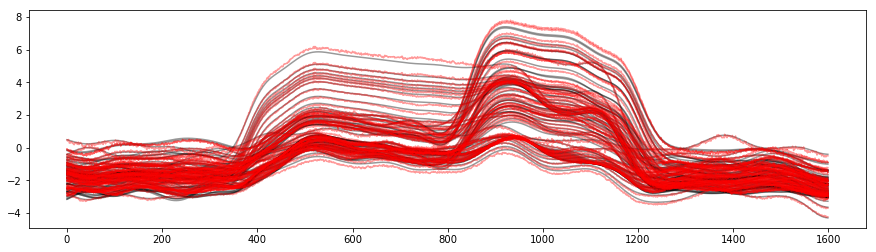

In [78]:
ntwrk = np.load('datasets/id001_ac/AC_network.npz')
gain = ntwrk['gain_mat']
src_sig = pstr_samples_1['x']
amplitude = pstr_samples_1['amplitude']
offset = pstr_samples_1['offset']
slp = np.zeros([src_sig.shape[0],src_sig.shape[1],gain.shape[0]])
for i,sample in enumerate(src_sig):
#     seeg[i] = amplitude[i,:] * ((gain @ sample.T).T + offset[i,:]);
    slp[i] = amplitude[i] * (np.log(gain @ np.exp(sample).T).T + offset[i])
    

mdld_data = np.load('datasets/id001_ac/AC_fit_trgt.npz')
plt.figure(figsize=(15,4))
plt.plot(mdld_data['fit_trgt'],'k',alpha=0.4);
plt.plot(slp[-1],'r', alpha=0.4);

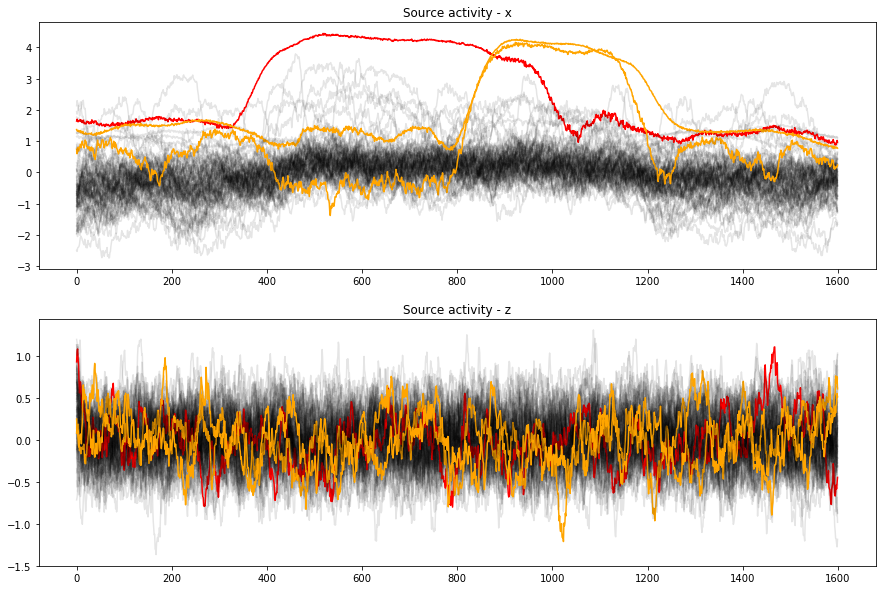

In [81]:
ez = [59]
pz = [74, 82]
plt.figure(figsize=(15,10))
ax_src_x = plt.subplot(211)
ax_src_z = plt.subplot(212)
sample_idx = -1
for i in range(84):
    if i in ez: 
        ax_src_x.plot(pstr_samples_1['x'][sample_idx,:,i], color='red');
        ax_src_z.plot(pstr_samples_1['z'][sample_idx,:,i], color='red');
    elif i in pz:
        ax_src_x.plot(pstr_samples_1['x'][sample_idx,:,i], color='orange');
        ax_src_z.plot(pstr_samples_1['z'][sample_idx,:,i], color='orange');
    else:
        ax_src_x.plot(pstr_samples_1['x'][sample_idx,:,i], color='black', alpha=0.1);
        ax_src_z.plot(pstr_samples_1['z'][sample_idx,:,i], color='black', alpha=0.1);
ax_src_x.set_title("Source activity - x")
ax_src_z.set_title("Source activity - z")


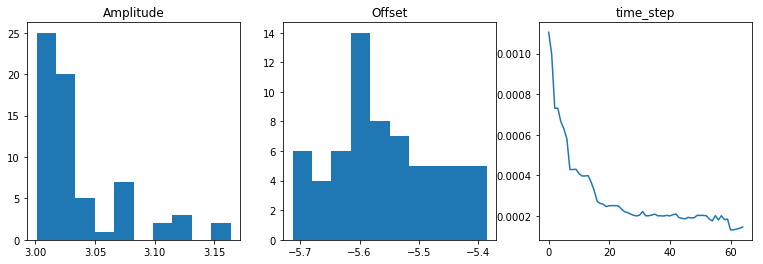

In [83]:
plt.figure(figsize=(13,4))
plt.subplot(131)
plt.hist(pstr_samples_1['amplitude'][50:].flatten())
plt.title('Amplitude')
plt.subplot(132)
plt.hist(pstr_samples_1['offset'][50:].flatten())
plt.title('Offset')
plt.subplot(133)
plt.plot(pstr_samples_1['time_step'][50:])
plt.title('time_step')
